In [2]:
# Replicate ITI results, make sure ITI utils and probing utils work right

#%%
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
    
import plotly.io as pio
# pio.renderers.default = "png"
# Import stuff

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

from tqdm import tqdm
# from utils.probing_utils import ModelActs
from utils.dataset_utils import CounterFact_Dataset, TQA_MC_Dataset, EZ_Dataset

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

from utils.iti_utils import patch_iti

from utils.analytics_utils import plot_probe_accuracies, plot_norm_diffs, plot_cosine_sims
import os
from torch import Tensor

/tmp/ipykernel_105379/82016879.py:8: DeprecationWarning:

`magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).

/tmp/ipykernel_105379/82016879.py:9: DeprecationWarning:

`magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).



## Format raw activations

Format unformatted activation files with each prompt being a single file, into formatted activations of each component's collated acts.

Only has to be done once.

In [3]:
run_id = 5
# N = 2550 #upper bound the global (level 0) index
d_head = 128
n_layers = 80
n_heads = 64
# num_params = "70b"

# reformat_acts_for_probing_fully_batched(run_id, N, d_head, n_layers, n_heads, "honest")
# reformat_acts_for_probing_fully_batched(run_id, N, d_head, n_layers, n_heads, "liar")
# reformat_acts_for_probing_fully_batched(run_id, N, d_head, n_layers, n_heads, "neutral")


## Initialize ModelActs objects. 

ModelActsLargeSimple is if we want to store all activations in memory at once (memory inefficient but faster transfer accuracy). 

ChunkedModelActs is if we don't want to keep activations in memory, instead load in activations in batches of layers and train probes iteratively, then unload activations. Transfer accuracy is much slower.

In [4]:
from utils.new_probing_utils import ModelActsLargeSimple, ChunkedModelActs

elem_acts_honest = ModelActsLargeSimple()
elem_acts_neutral = ModelActsLargeSimple()
elem_acts_liar = ModelActsLargeSimple()
# elem_acts_honest = ChunkedModelActs()
# elem_acts_neutral = ChunkedModelActs()
# elem_acts_liar = ChunkedModelActs()


modes = ["honest", "neutral", "liar"]
elem_acts = {"honest": elem_acts_honest, "neutral": elem_acts_neutral, "liar": elem_acts_liar}

# modes = ["honest", "liar"]
# elem_acts = {"honest": elem_acts_honest, "liar": elem_acts_liar}

In [47]:
seq_pos = -1
act_type = "z"
act_types = ["z", "mlp_out", "resid_mid"]
dataset_name = "azaria_mitchell_facts"
dont_include = None

for label in modes:
    
    for act_type in act_types:
        file_prefix = f"activations/formatted/run_{run_id}_{label}"
        if seq_pos is not None:
            file_prefix += f"_{seq_pos}"
        file_prefix += f"_{act_type}"
        if dataset_name is not None:
            file_prefix += f"_{dataset_name}"

        with open(f"activations/formatted/labels_{run_id}_{label}_{seq_pos}_{act_type}_{dataset_name}.pt", "rb") as handle:
            labels = torch.load(handle)
        # print(labels)

        elem_acts[label].load_acts(file_prefix, n_layers, n_heads=n_heads, labels=labels, exclude_points=dont_include, act_type=act_type)
        elem_acts[label].train_probes(act_type, verbose=True, max_iter=10000)
    # elem_acts[label].load_acts_per_layer(f"data/large_run_1/activations/formatted/large_run_1_{label}", n_layers, n_heads, labels, exclude_points=dont_include)


FileNotFoundError: [Errno 2] No such file or directory: 'activations/formatted/labels_5_honest_-1_resid_post_azaria_mitchell_facts.pt'

In [18]:
print(elem_acts["honest"].activations["mlp_out"][1].shape)
print(elem_acts["honest"].activations["resid_mid"][1].shape)
print(elem_acts["honest"].activations["z"][(1,1)].shape)
print(elem_acts["honest"].labels.shape)

(599, 8192)
(599, 8192)
(599, 128)
torch.Size([599])


In [29]:
def acc_tensor_from_dict(probe_accs_dict, n_layers, n_heads=None):
    if n_heads is not None:
        probe_accs = np.zeros(shape=(n_layers, n_heads))
        for layer in range(n_layers):
            for head in range(n_heads):
                probe_accs[layer, head] = probe_accs_dict[(layer, head)]

    else:
        probe_accs = np.zeros(shape=(n_layers,))
        for layer in range(n_layers):
            probe_accs[layer] = probe_accs_dict[layer]
    return probe_accs

In [32]:
act_type = "mlp_out"

from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=3)

from utils.analytics_utils import plot_z_probe_accuracies, plot_resid_probe_accuracies

for i, label in enumerate(modes):
    if act_type == "z":
        px_fig = plot_z_probe_accuracies(elem_acts[label].probe_accs[act_type], n_layers, n_heads, title = f"{label} {act_type} Probe Accuracies")
    else:
        px_fig = plot_resid_probe_accuracies(elem_acts[label].probe_accs[act_type], n_layers, title = f"{label} {act_type} Probe Accuracies")
    fig.add_trace(
        px_fig['data'][0],  # add the trace from plotly express figure
        row=1,
        col=i+1
    )

    if act_type == "z":
        fig.update_xaxes(title_text=f"Heads ({label})", row=1, col=i+1)
        fig.update_yaxes(title_text=px_fig.layout.yaxis.title.text, row=1, col=i+1)
    else:
        fig.update_xaxes(title_text=f"Layer ({label})", row=1, col=i+1)
        fig.update_yaxes(title_text=px_fig.layout.yaxis.title.text, row=1, col=i+1)

    print(acc_tensor_from_dict(elem_acts[label].probe_accs["z"], n_layers, n_heads).mean())

fig.update_layout(title_text=f"{act_type} Probe Accuracies, Dataset {dataset_name}", showlegend=False)
fig.show()

0.6919986979166667
0.6549397786458333
0.6023046875


In [45]:
act_type = "resid_mid"
if act_type == "z":
    transfer_acc_tensors = np.zeros(shape=(len(modes),len(modes), n_layers, n_heads))
else:
    transfer_acc_tensors = np.zeros(shape=(len(modes), len(modes), n_layers))

fig = make_subplots(rows=3, cols=3)

for idx1, mode in enumerate(modes, start=1):
    for idx2, other_mode in enumerate(modes, start=1):
        transfer_accs = {}
        for probe_index in tqdm(elem_acts["honest"].probes[act_type]):
            transfer_accs[probe_index] = elem_acts[mode].get_probe_transfer_acc(act_type, probe_index, elem_acts[other_mode])
        
        if act_type == "z":
            px_fig = plot_z_probe_accuracies(transfer_accs, n_layers, n_heads, title = f"Transfer Probe Accuracies, {act_type} Probes from {mode} tested on {other_mode}")
        else:
            px_fig = plot_resid_probe_accuracies(transfer_accs, n_layers, title = f"Transfer Probe Accuracies, {act_type} Probes from {mode} tested on {other_mode}")

        fig.add_trace(
            px_fig['data'][0],  # add the trace from plotly express figure
            row=idx1,
            col=idx2
        )
        if act_type == "z":
            transfer_acc_tensors[idx1-1, idx2-1] = acc_tensor_from_dict(transfer_accs, n_layers, n_heads)
        else:
            transfer_acc_tensors[idx1-1, idx2-1] = acc_tensor_from_dict(transfer_accs, n_layers)

  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:01<00:00, 67.76it/s]


In [43]:
for idx1, mode in enumerate(modes, start=0):
    print(f"For probes trained on {mode}, sum of transfer accuracies is {transfer_acc_tensors[idx1].sum()}")

For probes trained on honest, sum of transfer accuracies is 151.86644407345577
For probes trained on neutral, sum of transfer accuracies is 159.30717863105176
For probes trained on liar, sum of transfer accuracies is 148.77462437395658


In [46]:
for idx1 in range(1, 4):
    fig.update_xaxes(title_text=f"Tested on {modes[idx1-1]}", row=3, col=idx1)

for idx2 in range(1, 4):
    fig.update_yaxes(title_text=f"Trained on {modes[idx2-1]}", row=idx2, col=1)

fig.update_layout(title_text=f"Transfer {act_type} Probe Accuracies, trained on row and tested on column, Dataset {dataset_name}", height=1000)
fig.show()

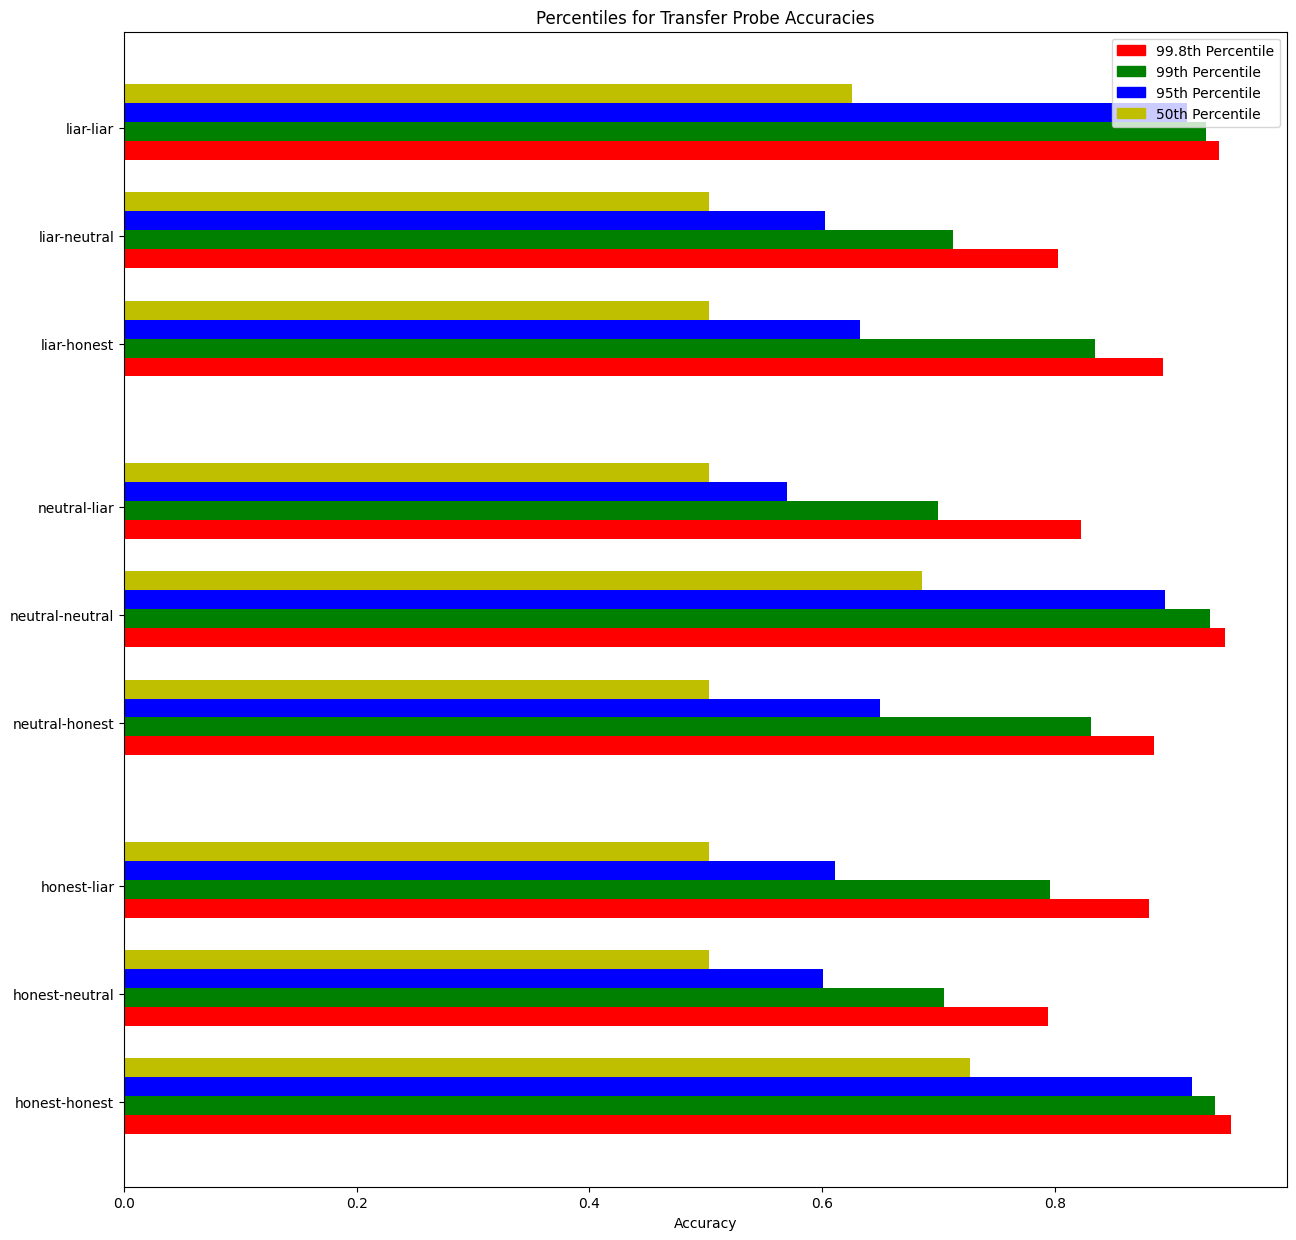

In [11]:
import matplotlib.pyplot as plt

percentiles = [99.8, 99, 95, 50]

def get_probe_percentiles(accs, percentiles):
    acc_percentiles = []
    for percentile in percentiles:
        acc_percentiles.append(np.percentile(accs, percentile))
    return acc_percentiles

# Set the figure size
plt.figure(figsize=(15, 15))

# Define the bar width
bar_width = 0.05

# Create lists to hold plot data
bar_positions = []
bar_heights = []
bar_labels = []
bar_colors = ['r', 'g', 'b', 'y']  # colors for different percentiles

for idx1, mode in enumerate(modes, start=1):
    for idx2, other_mode in enumerate(modes, start=1):
        acc_tensor = transfer_acc_tensors[idx1-1, idx2-1]
        probe_percentiles = get_probe_percentiles(acc_tensor, percentiles)
        
                # For each percentile, add a new bar
        for i, percentile in enumerate(probe_percentiles):
            bar_positions.append(idx1 + idx2/3.5 + i/20)  # increment position for each percentile
            bar_heights.append(percentile)
            bar_labels.append(f'{mode}-{other_mode}')
            
# Plot horizontal bar chart
plt.barh(bar_positions, bar_heights, color=bar_colors, height=bar_width)

# Set labels for y-ticks
# plt.yticks(bar_positions, bar_labels)
plt.yticks([idx1 + idx2/3.5 + 0.015*len(percentiles) for idx1, mode in enumerate(modes, start=1) for idx2, other_mode in enumerate(modes, start=1)], bar_labels[::len(percentiles)])

legends = {percentiles[i]: bar_colors[i] for i in range(len(percentiles))}
handles = [plt.Rectangle((0,0),1,1, color=legends[p]) for p in percentiles]
plt.legend(handles, [f'{p}th Percentile' for p in percentiles])

plt.title("Percentiles for Transfer Probe Accuracies")
plt.xlabel("Accuracy")
plt.show()

# Cosine Similarities of probe weights between ModelActs

In [58]:
fig = make_subplots(rows=3, cols=3)
act_type = "mlp_out"

if act_type == "z":
    cosine_similarities = np.zeros(shape=(len(modes),len(modes), n_layers, n_heads))
else:
    cosine_similarities = np.zeros(shape=(len(modes),len(modes), n_layers))

for idx1, mode in enumerate(modes, start=1):
    for idx2, other_mode in enumerate(modes, start=1):
        cos_sims = {}
        for probe_index in tqdm(elem_acts["honest"].probes[act_type]):
            coefs_1 = elem_acts[mode].probes[act_type] [probe_index].coef_.squeeze()
            coefs_2 = elem_acts[other_mode].probes[act_type] [probe_index].coef_.squeeze()
            cos_sims[probe_index] = np.dot(coefs_1, coefs_2)/(np.linalg.norm(coefs_1)*np.linalg.norm(coefs_2))


        if act_type == "z":
            px_fig = plot_z_probe_accuracies(cos_sims, n_layers, n_heads, title = f"Cosine Similarities, Probes from {mode} with {other_mode}")
            cosine_similarities[idx1-1, idx2-1] = acc_tensor_from_dict(cos_sims, n_layers, n_heads)

        else:
            px_fig = plot_resid_probe_accuracies(cos_sims, n_layers, title = f"Cosine Similarities, Probes from {mode} with {other_mode}", graph_type="square")
            cosine_similarities[idx1-1, idx2-1] = acc_tensor_from_dict(cos_sims, n_layers)

        fig.add_trace(
            px_fig['data'][0],  # add the trace from plotly express figure
            row=idx1,
            col=idx2
        )


for idx1 in range(1, 4):
    fig.update_xaxes(title_text=f"Tested on {modes[idx1-1]}", row=3, col=idx1)

for idx2 in range(1, 4):
    fig.update_yaxes(title_text=f"Trained on {modes[idx2-1]}", row=idx2, col=1)

fig.update_layout(title_text=f"Cosine Similarities of {act_type} Probe Coefficients", height=1000)
fig.show()

100%|██████████| 80/80 [00:00<00:00, 46129.27it/s]


100%|██████████| 80/80 [00:00<00:00, 61658.27it/s]


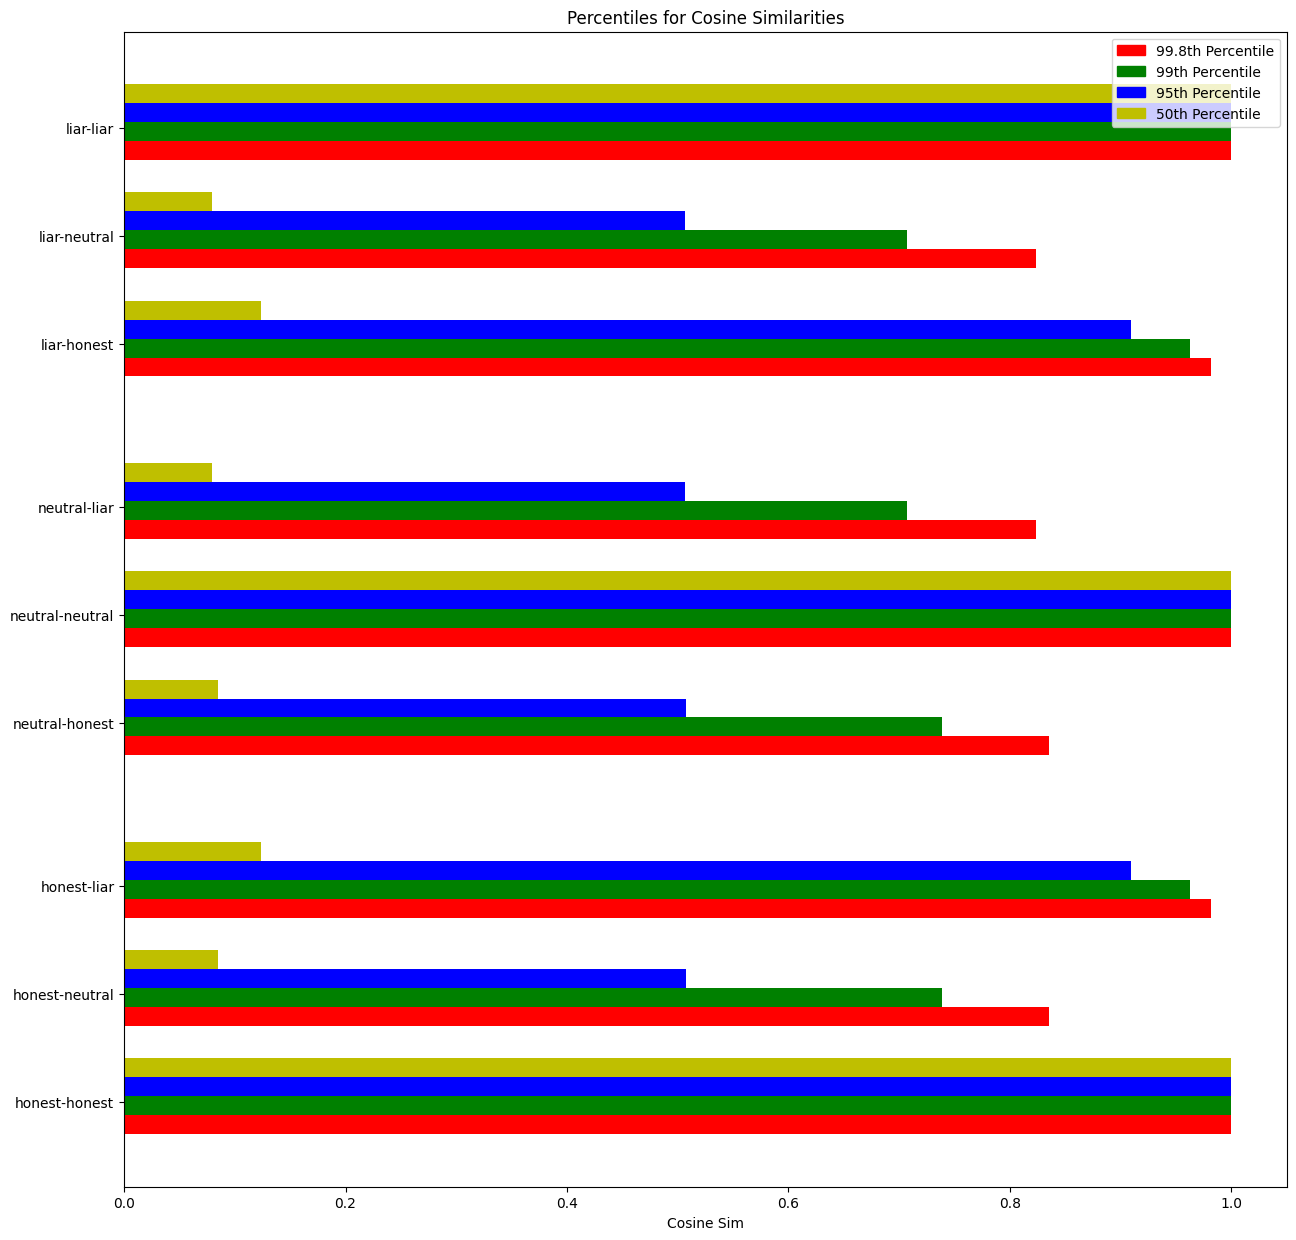

In [ ]:
import matplotlib.pyplot as plt

percentiles = [99.8, 99, 95, 50]

def get_probe_percentiles(accs, percentiles):
    acc_percentiles = []
    for percentile in percentiles:
        acc_percentiles.append(np.percentile(accs, percentile))
    return acc_percentiles

# Set the figure size
plt.figure(figsize=(15, 15))

# Define the bar width
bar_width = 0.05

# Create lists to hold plot data
bar_positions = []
bar_heights = []
bar_labels = []
bar_colors = ['r', 'g', 'b', 'y']  # colors for different percentiles

for idx1, mode in enumerate(modes, start=1):
    for idx2, other_mode in enumerate(modes, start=1):
        acc_tensor = cosine_similarities[idx1-1, idx2-1]
        probe_percentiles = get_probe_percentiles(acc_tensor, percentiles)
        
                # For each percentile, add a new bar
        for i, percentile in enumerate(probe_percentiles):
            bar_positions.append(idx1 + idx2/3.5 + i/20)  # increment position for each percentile
            bar_heights.append(percentile)
            bar_labels.append(f'{mode}-{other_mode}')
            
# Plot horizontal bar chart
plt.barh(bar_positions, bar_heights, color=bar_colors, height=bar_width)

# Set labels for y-ticks
# plt.yticks(bar_positions, bar_labels)
plt.yticks([idx1 + idx2/3.5 + 0.015*len(percentiles) for idx1, mode in enumerate(modes, start=1) for idx2, other_mode in enumerate(modes, start=1)], bar_labels[::len(percentiles)])

legends = {percentiles[i]: bar_colors[i] for i in range(len(percentiles))}
handles = [plt.Rectangle((0,0),1,1, color=legends[p]) for p in percentiles]
plt.legend(handles, [f'{p}th Percentile' for p in percentiles])

plt.title("Percentiles for Cosine Similarities")
plt.xlabel("Cosine Sim")
plt.show()

More Analytics: Bar Chart of probe accuracies at different percentiles, and graph plotting average probe accuracy vs layer

(80,)
(80,)
(80,)
(80,)


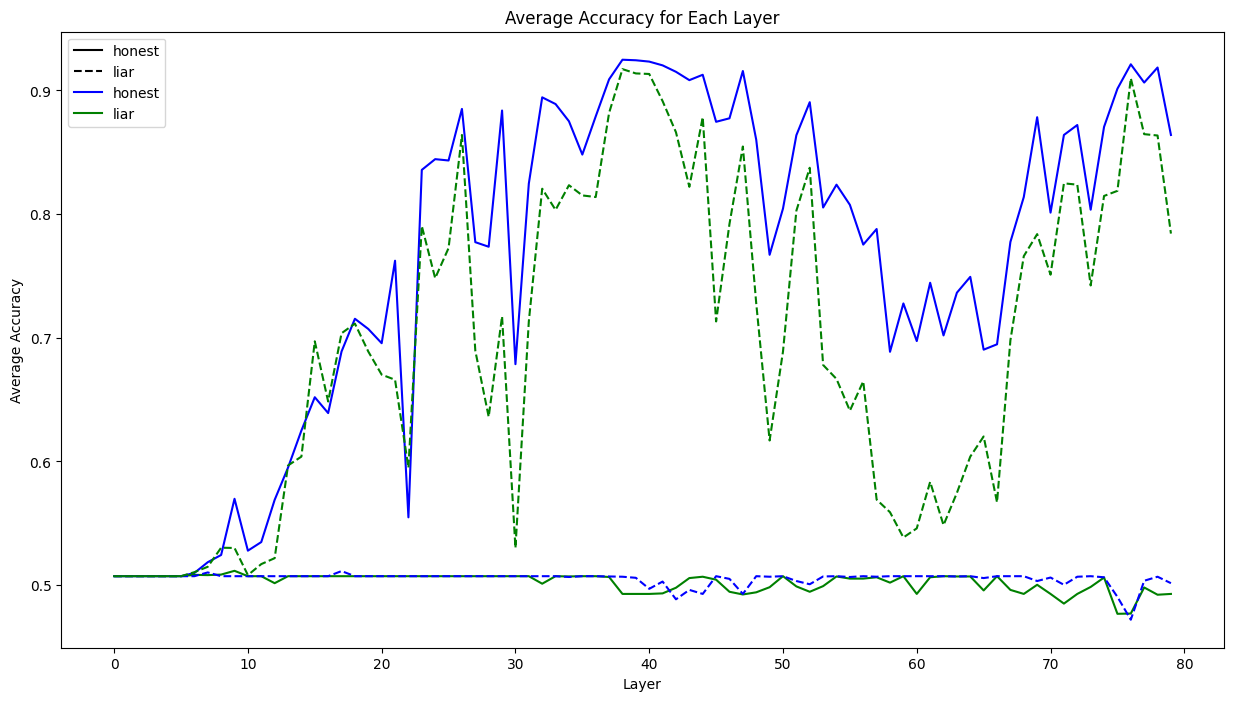

In [ ]:
def get_layer_accs(acc_tensor, percentile=50):
    layer_percentiles = []
    for layer in range(acc_tensor.shape[0]):
        layer_percentiles.append(np.percentile(acc_tensor[layer], percentile))
    return np.array(layer_percentiles)

# line_styles for each mode1
line_styles = ['-', '--', '-.']

# colors for each mode2
colors = ['b', 'g', 'r']

# Set the figure size
plt.figure(figsize=(15, 8))

# Loop through each mode1
for idx1, mode1 in enumerate(modes):
    # Loop through each mode2
    for idx2, mode2 in enumerate(modes):
        acc_tensor = transfer_acc_tensors[idx1, idx2]
        avg_acc = get_layer_accs(acc_tensor, percentile=50)
        print(avg_acc.shape)
        # Create a line graph with specific line style and color for each mode pair
        plt.plot(avg_acc, linestyle=line_styles[idx1 % len(line_styles)], color=colors[idx2 % len(colors)], label=f'{mode1}-{mode2}')

plt.xlabel('Layer')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for Each Layer')

from matplotlib.lines import Line2D  # for creating custom legend
legend_elements = [Line2D([0], [0], color='k', linestyle=line_styles[i], label=modes[i]) for i in range(len(modes))] + \
                  [Line2D([0], [0], color=colors[i], linestyle='-', label=modes[i]) for i in range(len(modes))]

plt.legend(handles=legend_elements)

plt.show()